# Song Popularity

## Load the Data

Data can be found here: https://www.kaggle.com/datasets/tonygordonjr/spotify-dataset-2023?select=spotify_data_12_20_2023.csv

In [80]:
# Load the data
import pandas as pd
import numpy as np

data: pd.DataFrame = pd.read_csv("spotify_data_12_20_2023.csv")

if "duration_ms" in data.columns and "duration_sec" in data.columns:
    data.drop(columns=["duration_sec"], inplace=True)

# TODO: Drop rows SELECTIVELY
print(data.isna().sum())
hardcoded_drop_columns: list[str] = [
    "rn",
    "uri",
    "track_number",
    "analysis_url",
    "track_href",
    "artist_0",
    "artist_1",
    "artist_2",
    "artist_3",
    "artist_4",
    "type",
    "total_tracks"
]
data.drop(columns=hardcoded_drop_columns, inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.dropna(
    axis=0,
    subset=[
        "track_popularity",
        "tempo",
        "acousticness",
        "danceability",
        "release_year",
    ],
    inplace=True,
)
print(data.isna().sum())


# BUG: DtypeWarning: Columns (25,26,44) have mixed types
print(data.columns)


# Professor suggestions:
####
# Split it into "model" trees
# Figure out if there are bounds where it is extremely accurate
# Find a cutoff

# Pick a random 10k instead of 300k
# Calculate a balanced accuracy
# The balanced accuracy as a function of split is a curve that peaks somewhere
# If it is smooth then you can do a binary search
####

# TODO: Replace columns like genre with numerical values

# TODO: Capitalizeed letter after apostrophe in track titles

# TODO: Take a bit out as a test set


C:\Users\alexa\AppData\Local\Temp\ipykernel_18712\2949754244.py:5: DtypeWarning: Columns (25,26,44) have mixed types. Specify dtype option on import or set low_memory=False.
  data: pd.DataFrame = pd.read_csv("spotify_data_12_20_2023.csv")


album_id                  0
album_name                1
album_popularity          0
album_type                0
artists                   0
artist_0                  2
artist_1             288062
artist_2             336841
artist_3             361318
artist_4             369054
artist_id                 0
label                    52
release_date             22
total_tracks              0
track_id                  0
track_name                5
track_number              0
artist_genres             0
artist_popularity         0
followers                 0
name                      0
genre_0              165278
genre_1              255655
genre_2              297922
genre_3              326531
genre_4              343824
acousticness            777
analysis_url            777
danceability            777
duration_ms             777
energy                  777
instrumentalness        777
key                     777
liveness                777
loudness                777
mode                

## Decision Trees

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    root_mean_squared_error,
    roc_auc_score,
    accuracy_score,
)
import matplotlib.pyplot as plt

assert data is not None

x = data.select_dtypes(include="number", exclude="int64").drop(
    columns=["track_popularity"]
)

# TODO: Train the track_popularity number
y = (data["track_popularity"] > 50).astype(int)

# Show the distribution of the track_popularity on the above threshold
print(y.value_counts(normalize=True))

# MAX_DEPTH = 7
dt = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=x.size,
    max_features="sqrt",
    class_weight="balanced",  # Make the 1's have more hold
)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=x.size
)
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
y_pred_proba = dt.predict_proba(x_test)[:, 1]  # type: ignore

accuracy = accuracy_score(y_test, y_pred)
area_under_curve = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:0.4f}")
print(f"Area Under Curve: {area_under_curve:0.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):0.4f}")


FEATURE = "loudness"
assert FEATURE in x.columns

# Random sample the data for visualization
SAMPLE_SIZE = min(3000, len(x_test))
sample_index = np.random.choice(len(x_test), size=SAMPLE_SIZE, replace=False)

x_sample = x_test.iloc[sample_index]
y_sample = y_test.iloc[sample_index]
y_pred_sample = y_pred[sample_index]
print(y_pred_sample)

track_popularity
0    0.964604
1    0.035396
Name: proportion, dtype: float64
Accuracy: 0.9147
Area Under Curve: 0.5767
RMSE: 0.2921
[0 0 0 ... 0 0 0]


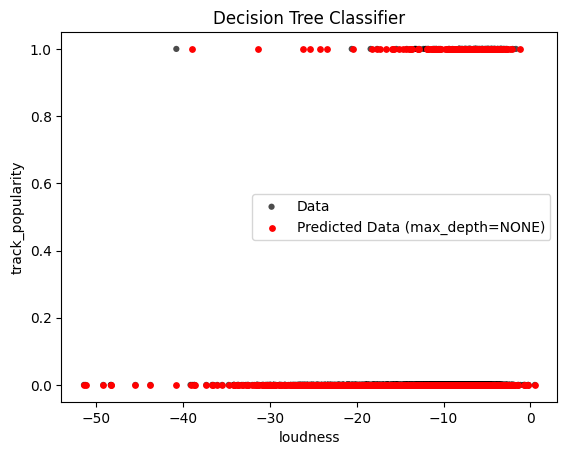

In [97]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#plot-the-results
plt.figure()
plt.scatter(
    x_sample[FEATURE],
    y_sample,
    s=20,
    alpha=0.7,
    edgecolor="none",
    c="black",
    label="Data",
)
plt.scatter(
    x_sample[FEATURE],
    y_pred_sample,
    color="red",
    s=15,
    alpha=1,
    label="Predicted Data (max_depth=NONE)",
)
# sns.pairplot(data, vars=x.columns, y_vars="track_popularity", hue="track_popularity")
# plt.plot(x_test[FEATURE], y_pred, color="red", label=f"max_depth={MAX_DEPTH}", linewidth=2)
plt.xlabel(FEATURE)
plt.ylabel("track_popularity")
plt.title("Decision Tree Classifier")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

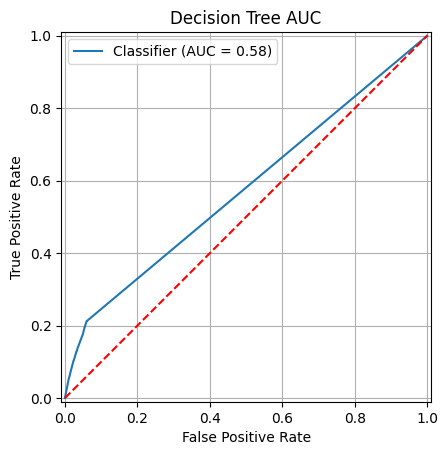

In [100]:
# Plot the decision tree AUC
from sklearn.metrics import RocCurveDisplay

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# A good decision tree will have a HIGH AUC (0.8+), high TPR with low FPR.
plt.figure()
rcd: RocCurveDisplay = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
# rcd.plot()
# plt.plot(fpr, tpr, label=f"Decision Tree (AUC={area_under_curve:0.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree AUC")
plt.grid(True)
plt.legend()
plt.show()